# Test our Ecohydrology module

This notebook is to test that importing and using our implementation of the Ecohydrology model works. 

In [1]:
from ecohydr_mod import EcoHyd
import numpy as np

In [2]:
WSA_array = np.zeros((51,51))
# Set 20 random values to 1
indices_to_set = np.random.choice(range(51 * 51), size=20, replace=False)
row_indices, col_indices = np.unravel_index(indices_to_set, (51, 51))
WSA_array[row_indices, col_indices] = int(1)

Ecohyd_model = EcoHyd()

In [3]:
import matplotlib.pyplot as plt

In [4]:
biomass_harvest, SM_canic_end = Ecohyd_model.stepper(WSA_array)

1
0.0027397260273972603
soil moisture sat.: [ 0.61946873  0.61937855  0.61929183 ...,  0.64909105  0.64913643
  0.64918345]
live biomass:  [ 0.  0.  0. ...,  0.  0.  0.]
ET:  [ 11.87824236  11.89491558  11.91094527 ...,   6.21423808   6.20523659
   6.19590912]
ET30:  [ 11.87824236  11.89491558  11.91094527 ...,   6.21423808   6.20523659
   6.19590912]
PFT:  [3 3 3 ..., 3 3 3]
0
0
soil moisture sat.: [ 0.55290533  0.55274893  0.55259853 ...,  0.60281879  0.60289264
  0.60296915]
live biomass:  [ 0.  0.  0. ...,  0.  0.  0.]
ET:  [ 11.87824236  11.89491558  11.91094527 ...,   6.21423808   6.20523659
   6.19590912]
ET30:  [ 11.87824236  11.89491558  11.91094527 ...,   6.21423808   6.20523659
   6.19590912]
PFT:  [3 3 3 ..., 3 3 3]
0
0.0027378507871321013
soil moisture sat.: [ 0.49957055  0.4993558   0.49914938 ...,  0.57100568  0.5711102
  0.57121846]
live biomass:  [ 0.  0.  0. ...,  0.  0.  0.]
ET:  [ 11.87824236  11.89491558  11.91094527 ...,   6.21423808   6.20523659
   6.19590912]
ET

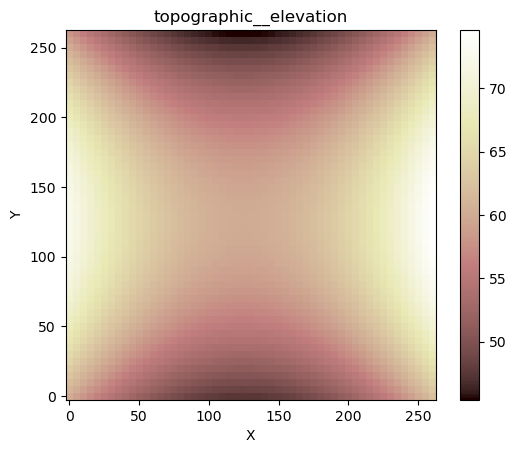

In [5]:
from landlab.plot.imshow import imshow_grid_at_node
#N.B. the Landlab user guide tells you to import the wrong component here

plt.figure('Elevations from the field')  # new fig, with a name
imshow_grid_at_node(Ecohyd_model.mg, 'topographic__elevation') 
plt.show()

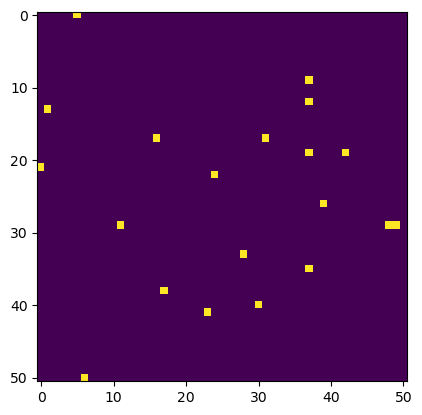

In [6]:
plt.imshow(WSA_array)

N.B the following images are all flipped upside-down because np.reshape assumes by default that the origin is in the top left, not the bottom left.

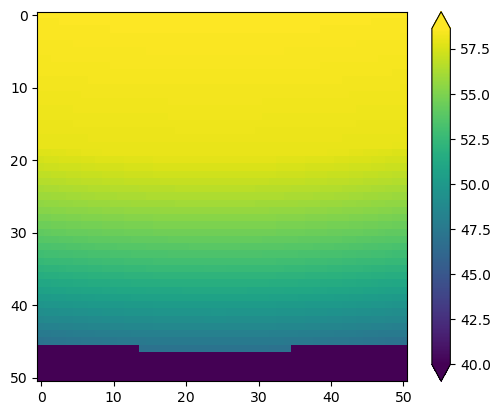

In [8]:
plt.imshow(np.reshape(biomass_harvest, (51,51)), vmin=40)
plt.colorbar(extend = 'both')

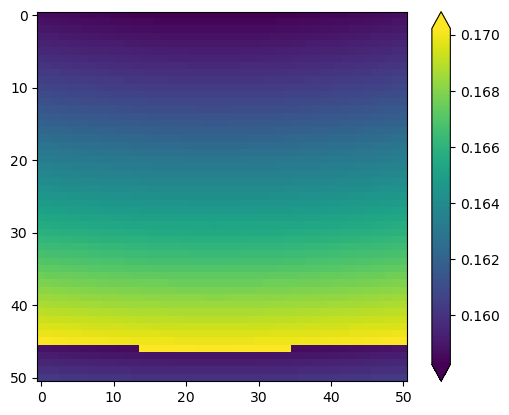

In [10]:
plt.imshow(np.reshape(SM_canic_end, (51,51)))
plt.colorbar(extend = 'both')

WSA does not seem to make any difference whatsoever for the soil moisture at the end of the canicula period. :(((

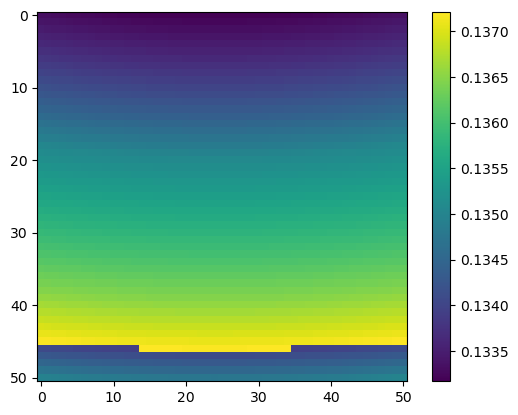

In [40]:
SM = np.reshape(Ecohyd_model.mg.at_cell['soil_moisture__saturation_fraction'], (51,51))
plt.imshow(SM)
plt.colorbar()

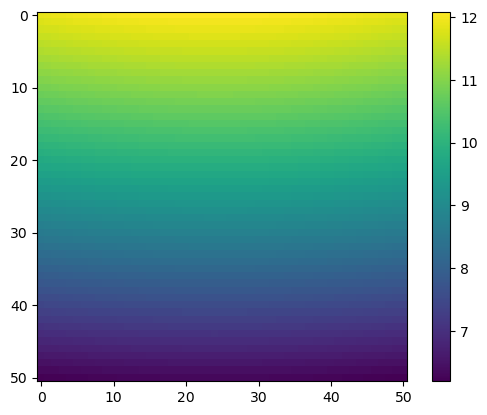

In [41]:
ET = np.reshape(Ecohyd_model.mg.at_cell['surface__potential_evapotranspiration_rate'], (51,51))
plt.imshow(ET)
plt.colorbar()

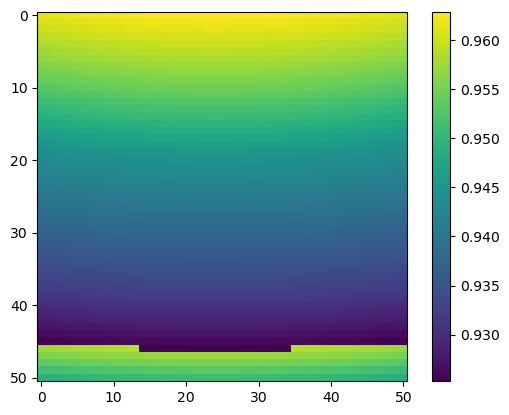

In [42]:
WS = np.reshape(Ecohyd_model.mg.at_cell['vegetation__water_stress'], (51,51))
plt.imshow(WS)
plt.colorbar()

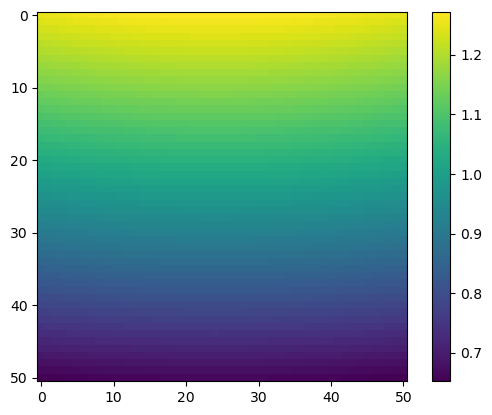

In [43]:
Rad_slope = np.reshape(Ecohyd_model.mg.at_cell['radiation__ratio_to_flat_surface'], (51,51))
plt.imshow(Rad_slope)
plt.colorbar()

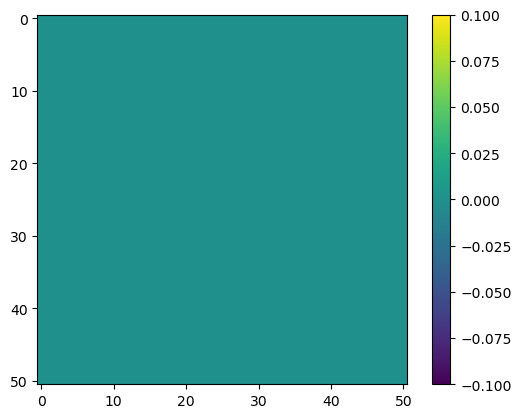

In [44]:
rad = np.reshape(Ecohyd_model.mg.at_cell['radiation__net_flux'], (51,51))
plt.imshow(rad)
plt.colorbar()